
# MNIST with Keras

We will go through the following steps:
1. Importing libraries and the dataset
2. Data preparation
3. Building and understanding CNN architecture
4. Fitting and evaluating the model

## 1. Importing libraries and the dataset


In [1]:
# Utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow and keras
import tensorflow as tf
from keras.datasets import mnist

In [2]:
# Parameters

IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Model
NO_EPOCHS = 5
BATCH_SIZE = 128
VERBOSE = 1
PATIENCE = 20

In [3]:
# load the dataset into test and train sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Get class distribution

print(pd.Series(y_train).value_counts())

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64


## 2. Data preparation

We will get only 20k images for training, to save time.
Also, the pixel values of the images range from 0 through 255. We scale these values to a range 0 to 1 by dividing their values by 255.0.

In [4]:
# get only 20k images for training
idx = np.random.randint(x_train.shape[0], size=20000)
x_train = x_train[idx, :]
y_train = y_train[idx]
x_train, x_test = x_train / 255.0, x_test / 255.0

To verify that the data is in the correct format and that we are ready to build and train the network, let's display the first 25 images from the training set and display the class name below each image.

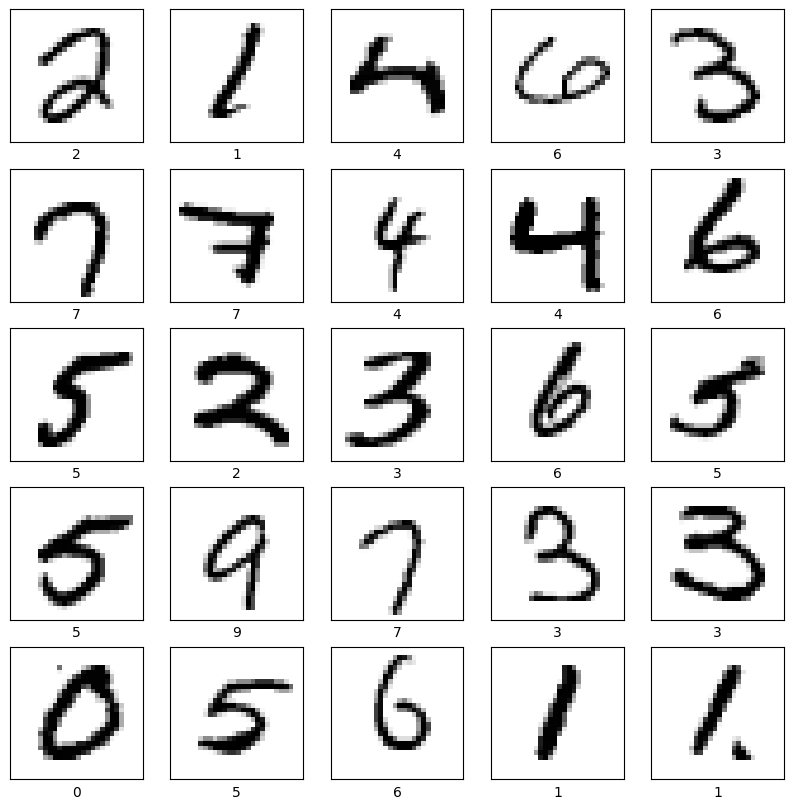

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

## 3. Building the model

We will build the network with:
- 2 convolutional layers having 32 and 64 filters respectively
- a max pooling layer
- Flatten the output of the pooling layer to give us a long vector
- full connected dense layer with 128 neurons
- a softmax layer with 10 neurons

To build a model in Keras -> instantiate a `Sequential` model and keep adding `keras.layers` to it. We will also use some dropouts.

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_ROWS, IMG_COLS, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(input_shape=(IMG_ROWS, IMG_COLS)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

Define a loss function for training using `losses.SparseCategoricalCrossentropy`. The loss function takes a vector of ground truth values and a vector of logits and returns a scalar loss for each example. The loss is equal to the negative log probability of the true class -> if the loss is 0, then the model is sure for the correct class.

In [7]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## 4. Fitting and evaluating the model

In [8]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=NO_EPOCHS)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8107 - loss: 0.5935
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9623 - loss: 0.1210
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9728 - loss: 0.0845
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9809 - loss: 0.0631
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9843 - loss: 0.0487


The `model.evaluate` method checks the model's performance usually on a validation set or test set.

In [11]:
model.evaluate(x_test, y_test, verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 - 2s - 5ms/step - accuracy: 0.9845 - loss: 0.0494


[0.04936772212386131, 0.984499990940094]

Now let's plot learning curves. First accuracy:

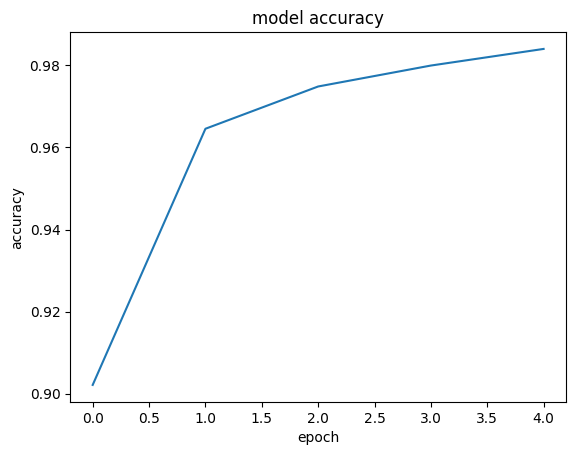

In [12]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

Second loss:

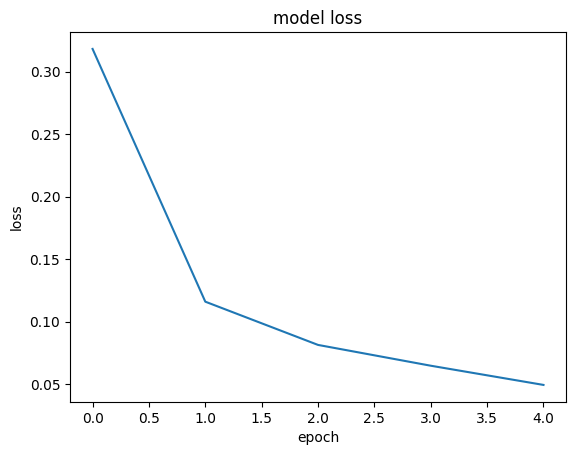

In [13]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()